The following document contains analysis of cybersecurity data, both adapted from existing code found from the internet and written myself in Python.

I have analysed in depth 2 sets of data from different sources, with a brief look at another data set. These data sets are listed in the resources section at the bottom of the document.

The following pre-requisites are required and this block should be run first so that the suitable packages are loaded in.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
!pip install squarify
import squarify
import zipfile
from urllib.parse import urlparse

  Using cached squarify-0.4.3-py3-none-any.whl (4.3 kB)


## Analysis of FTP dataset

FTP stands for File Transfer Protocol. It is a network protocol found in the application layer used to facilitate the transferral of computer files between a client and a server on a network.

We first need to import the dataset (which is in comma seperated value format) from Google Drive to our workspace.

In [8]:
orig_url='https://drive.google.com/file/d/1WemTdLui2MkjG_9ykm2_KPhL1FFfKmiL/view'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
ftp_df = pd.read_csv(csv_raw)

We have used the "pandas" package to read the csv into the more easily analysable form of a data frame. Next we perform an initial analysis on the dataframe ftp_df.

In [9]:
#DataFrame with columns
columns = pd.DataFrame(list(ftp_df.columns.values[1:]))

#DataFrame with data types
data_types = pd.DataFrame(ftp_df.dtypes, columns=['Data Type'])

#DataFrame with Count
data_count = pd.DataFrame(ftp_df.count(), columns=['Count'])

#DataFrame with unique values
unique_value_counts = pd.DataFrame(columns=['Unique Values'])
for v in list(ftp_df.columns.values):
    unique_value_counts.loc[v] = [ftp_df[v].nunique()]

missing_data_counts = pd.DataFrame(ftp_df.isnull().sum(), columns=['Missing Values'])
data_quality_report = data_types.join(data_count).join(unique_value_counts).join(missing_data_counts)
print('Data Quality Report')
data_quality_report

Data Quality Report


,Data Type,Count,Unique Values,Missing Values
ts,float64,5796,2390,0
uid,object,5796,137,0
id.orig_h,object,5796,15,0
id.orig_p,int64,5796,95,0
id.resp_h,object,5796,21,0
id.resp_p,int64,5796,1,0
user,object,5796,4,0
password,object,5745,12,51
command,object,5796,6,0
arg,object,2966,1545,2830


To get an impression of what the data looks like, and in doing so check that we have correctly imported the data, we use the head command in order to get a snapshot of the first few terms of our dataframe and see what kind of data is stored in it.

In [10]:
ftp_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,user,password,command,arg,mime_type,file_size,reply_code,reply_msg,passive,orig_h,resp_h,resp_p,fuid
0,1.331904e+09,CNFo204HUpVHDn1qt2,192.168.203.45,34433,192.168.21.101,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,101,219,204).",T,192.168.203.45,192.168.21.101,56268.0,NaN
1,1.331904e+09,CyHkLo2YfhjddpbSVl,192.168.203.45,56158,192.168.21.103,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,103,192,28)",T,192.168.203.45,192.168.21.103,49180.0,NaN
2,1.331904e+09,CotBpLi55vt2fNqm7,192.168.202.96,40138,192.168.28.101,21,<unknown>,NaN,PORT,\x1d\x93!\xf8t\x1ck\xd64\x05\xbb\xbeyu$\x152\x...,NaN,NaN,220.0,ProFTPD 1.3.4rc2 Server (Debian) [::ffff:172.1...,NaN,NaN,NaN,NaN,NaN
3,1.331904e+09,CptK3340W66OKHK3Rd,192.168.202.96,43740,192.168.28.103,21,<unknown>,NaN,PORT,\xbe\xb9wN\x11\xd1\xe1yH\xb8fI\x86\xfdvG\x80\x...,NaN,NaN,530.0,Please log in with USER and PASS first.,NaN,NaN,NaN,NaN,NaN
4,1.331904e+09,C3NlQu4G9w4W3TGSj7,192.168.204.45,50584,192.168.21.101,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,101,163,245).",T,192.168.204.45,192.168.21.101,41973.0,NaN


From looking at the data itself and from experience of looking at similar data from examples we recognize that as this data is logging various connections, the first column should be a timestamp of when each connection is initiated. This makes sense as the first column is labelled ts, obviously short for timestamp, however the data in the table doesn't look much like a timestamp at all. This is due to the way the data has been formatted, however we can use the python package datetime to fix this.

In [11]:
ftp_df["ts"].values[1]
print("This is the format of the ts data before transformation:\n", ftp_df["ts"], "\n\nWith the datatype shown at the bottom.")

This is the format of the ts data before transformation:
 0       1.331904e+09
1       1.331904e+09
2       1.331904e+09
3       1.331904e+09
4       1.331904e+09
            ...     
5791    1.332016e+09
5792    1.332016e+09
5793    1.332016e+09
5794    1.332016e+09
5795    1.332016e+09
Name: ts, Length: 5796, dtype: float64 

With the datatype shown at the bottom.


In [12]:
from datetime import datetime
ftp_df['ts'] = [datetime.fromtimestamp(float(date)) for date in ftp_df['ts'].values]
print("This is the format of the ts data after transformation:\n", ftp_df["ts"], "\n\nWith the datatype shown at the bottom.")

This is the format of the ts data after transformation:
 0      2012-03-16 13:12:38.160
1      2012-03-16 13:12:40.090
2      2012-03-16 13:12:38.950
3      2012-03-16 13:12:41.260
4      2012-03-16 13:25:01.560
                 ...          
5791   2012-03-17 20:21:30.290
5792   2012-03-17 20:21:34.700
5793   2012-03-17 20:21:49.730
5794   2012-03-17 20:21:55.460
5795   2012-03-17 20:22:19.970
Name: ts, Length: 5796, dtype: datetime64[ns] 

With the datatype shown at the bottom.


We now see that by parsing the timestamp column through the above function we now have something readable as a date rather than a long string of numbers, this makes it far nicer for us to read the dataframe. We notice that the data type has changed to a "datetime" format, opposed to the previous "float".

However the readability could still be improved, to do this we will rename the columns to something more user friendly. I have done some research into what each part of the dataframe means and have therefore selected suitable column names accordingly, using the rename() function of the pandas package.

In [13]:
ftp_df.rename(columns = {"ts":"Timestamp","uid":"User ID","id.orig_h":"Originating IP","id.resp_h":"Recieving IP","id.orig_p":"Originating Port","id.resp_p":"Recieving Port"}, inplace = True)
ftp_df.head()

,Timestamp,User ID,Originating IP,Originating Port,Recieving IP,Recieving Port,user,password,command,arg,mime_type,file_size,reply_code,reply_msg,passive,orig_h,resp_h,resp_p,fuid
0,2012-03-16 13:12:38.160,CNFo204HUpVHDn1qt2,192.168.203.45,34433,192.168.21.101,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,101,219,204).",T,192.168.203.45,192.168.21.101,56268.0,NaN
1,2012-03-16 13:12:40.090,CyHkLo2YfhjddpbSVl,192.168.203.45,56158,192.168.21.103,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,103,192,28)",T,192.168.203.45,192.168.21.103,49180.0,NaN
2,2012-03-16 13:12:38.950,CotBpLi55vt2fNqm7,192.168.202.96,40138,192.168.28.101,21,<unknown>,NaN,PORT,\x1d\x93!\xf8t\x1ck\xd64\x05\xbb\xbeyu$\x152\x...,NaN,NaN,220.0,ProFTPD 1.3.4rc2 Server (Debian) [::ffff:172.1...,NaN,NaN,NaN,NaN,NaN
3,2012-03-16 13:12:41.260,CptK3340W66OKHK3Rd,192.168.202.96,43740,192.168.28.103,21,<unknown>,NaN,PORT,\xbe\xb9wN\x11\xd1\xe1yH\xb8fI\x86\xfdvG\x80\x...,NaN,NaN,530.0,Please log in with USER and PASS first.,NaN,NaN,NaN,NaN,NaN
4,2012-03-16 13:25:01.560,C3NlQu4G9w4W3TGSj7,192.168.204.45,50584,192.168.21.101,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,101,163,245).",T,192.168.204.45,192.168.21.101,41973.0,NaN


Now we have made the data more readable, let's use a useful function called describe() to give a nice summary of some of the data.

In [14]:
ftp_df.describe()

,Originating Port,Recieving Port,file_size,reply_code,resp_p
count,5796.000000,5796.0,1.050000e+02,5756.000000,2897.000000
mean,6005.675293,21.0,2.920704e+04,380.597290,46721.828788
std,9053.257962,0.0,2.520387e+05,161.458602,8486.953844
min,1037.000000,21.0,0.000000e+00,200.000000,1054.000000
25%,3885.000000,21.0,2.840000e+02,227.000000,39840.000000
50%,4295.000000,21.0,1.245000e+03,227.000000,46659.000000
75%,4970.000000,21.0,6.286000e+03,550.000000,53991.000000
max,60541.000000,21.0,2.585932e+06,550.000000,61000.000000


An interesting observation I can make at this point is that from our our call to the head function we only saw NaN options for in the file_size column, however according to describe (that provides information about numerical columns) we can see that somewhere in the dataframe entries have value so there must be some data being sent between devices.

### Specific analysis on File Size

We will filter the data by only those rows that have a non NaN file_size i.e. more than 0.

In [15]:
ftp_df_file = ftp_df[ftp_df['file_size'] > 0]
ftp_df_file

,Timestamp,User ID,Originating IP,Originating Port,Recieving IP,Recieving Port,user,password,command,arg,mime_type,file_size,reply_code,reply_msg,passive,orig_h,resp_h,resp_p,fuid
9,2012-03-16 13:37:46.670,CX2CaPOLTnneF2vB3,192.168.24.100,1053,192.168.202.92,21,ftp,password,RETR,ftp://192.168.202.92/./svchost.exe,application/x-dosexec,6656.0,226.0,Transfer complete.,NaN,NaN,NaN,NaN,FyhsRF3Pe3mNtgF8kh
11,2012-03-16 13:40:30.500,Cc63op2xChkQcGt0i1,192.168.27.100,1150,192.168.202.92,21,ftp,password,RETR,ftp://192.168.202.92/./svchost.exe,application/x-dosexec,6656.0,226.0,Transfer complete.,NaN,NaN,NaN,NaN,FJfc4p1bUhOPvW0BWk
5521,2012-03-16 20:48:14.990,CCNcnvTzNNxo2UrW6,192.168.202.94,39218,192.168.25.101,21,anonymous,password,RETR,ftp://192.168.25.101/bash_logout,NaN,220.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,NaN
5523,2012-03-16 20:48:15.030,CCNcnvTzNNxo2UrW6,192.168.202.94,39218,192.168.25.101,21,anonymous,password,RETR,ftp://192.168.25.101/bashrc,text/plain,3353.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,FguByX20C4aW4zuM35
5525,2012-03-16 20:48:15.040,CCNcnvTzNNxo2UrW6,192.168.202.94,39218,192.168.25.101,21,anonymous,password,RETR,ftp://192.168.25.101/profile,NaN,675.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,FguByX20C4aW4zuM35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5750,2012-03-17 13:58:31.040,C9Jq442ff1JhSB0UA8,192.168.202.138,55780,192.168.25.101,21,anonymous,justinwray@justinwray.com,RETR,ftp://192.168.25.101/dept/qdept/registration.py,text/x-python,1833.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,FN0I4S1OOxsdB6296d
5752,2012-03-17 13:58:40.710,C9Jq442ff1JhSB0UA8,192.168.202.138,55780,192.168.25.101,21,anonymous,justinwray@justinwray.com,RETR,ftp://192.168.25.101/dept/qdept/qdept.db,binary,7168.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,FlyBLKuOiUW1CyVD3
5754,2012-03-17 13:58:59.760,C9Jq442ff1JhSB0UA8,192.168.202.138,55780,192.168.25.101,21,anonymous,justinwray@justinwray.com,RETR,ftp://192.168.25.101/dept/qdept/schema.sql,NaN,720.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,FlyBLKuOiUW1CyVD3
5763,2012-03-17 15:00:23.140,Cyu7iq43iCYtaQE8ud,192.168.202.138,56841,192.168.27.101,21,anonymous,anon@lulz.com,RETR,ftp://192.168.27.101/./dept/qdept/qdept.db,binary,7168.0,421.0,No transfer timeout (600 seconds): closing con...,NaN,NaN,NaN,NaN,FhzIDcUNPJqWBMuc5


From the bottom of this sub Dataframe we see that it features 101 rows, which means that out of all of the 5796 entries in the frame only 101 of them show a transferral of data.

It is safe to assume that the numbers in file_size are a representation of bytes, as this is the fundamental measurement of size in computers. If we look back at our describe function from above we see that the maximum file_size = 2.585932e+06 or 2585932. While that may sound large, in bytes that is actually quite a small file in modern computing only representing 2.585932 megabytes, which is about the size of a large png; I have a png on my hardrive that is 2100x2100 pixels that is 2.48 mb.

We see that overall the mean file size sent is about 29kb however if we look at this just on the filtered data (no NaN files) we find:

In [16]:
ftp_df_file.describe()

,Originating Port,Recieving Port,file_size,reply_code,resp_p
count,101.000000,101.0,1.010000e+02,101.000000,0.0
mean,39530.544554,21.0,3.036375e+04,227.930693,NaN
std,10235.699628,0.0,2.569611e+05,19.403225,NaN
min,1053.000000,21.0,2.000000e+00,226.000000,NaN
25%,39226.000000,21.0,2.900000e+02,226.000000,NaN
50%,39226.000000,21.0,1.401000e+03,226.000000,NaN
75%,39226.000000,21.0,6.656000e+03,226.000000,NaN
max,56841.000000,21.0,2.585932e+06,421.000000,NaN


We find that it is slightly larger at 30.36 kb. 

I am now going to plot the size size of file against the time the connection was completed using a scatter graph. Along the bottom of the graph we will see the timestamp in the form of the date (American format) and the hour of the day at which the transfer occured.

(array([734578.625, 734578.75 , 734578.875, 734579.   , 734579.125,
        734579.25 , 734579.375, 734579.5  , 734579.625]),
 <a list of 9 Text major ticklabel objects>)

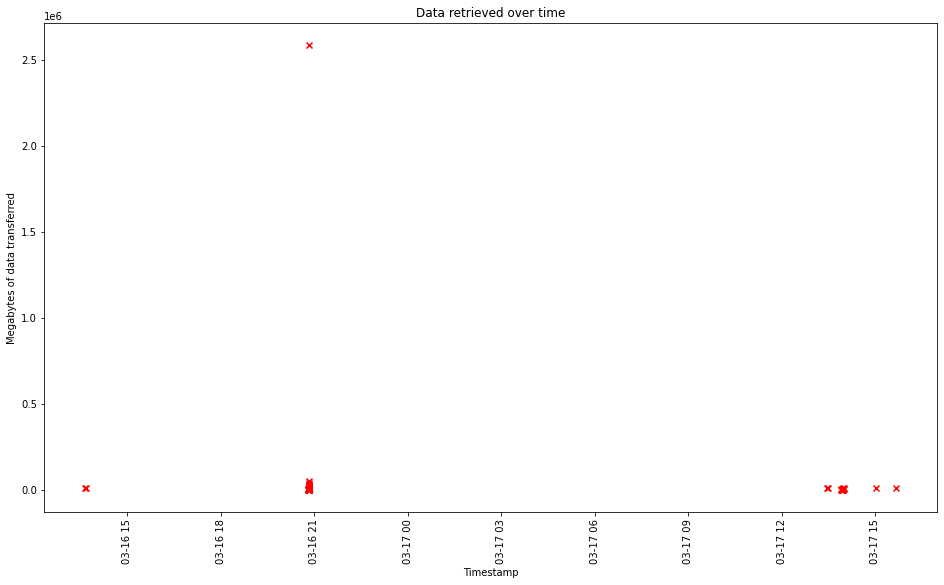

In [17]:
plt.figure(figsize=(16,9))
plt.scatter(ftp_df_file["Timestamp"],ftp_df_file["file_size"],marker ="x",c = "red")
plt.xlabel('Timestamp')
plt.ylabel('Megabytes of data transferred')
plt.title('Data retrieved over time')
plt.xticks(rotation=90)

We see that our maximum value of 2.5 MB is an outlier for most of the data traffic over this period so we will plot another scatter graph that is strictly for the values less than it.

(array([734578.625, 734578.75 , 734578.875, 734579.   , 734579.125,
        734579.25 , 734579.375, 734579.5  , 734579.625]),
 <a list of 9 Text major ticklabel objects>)

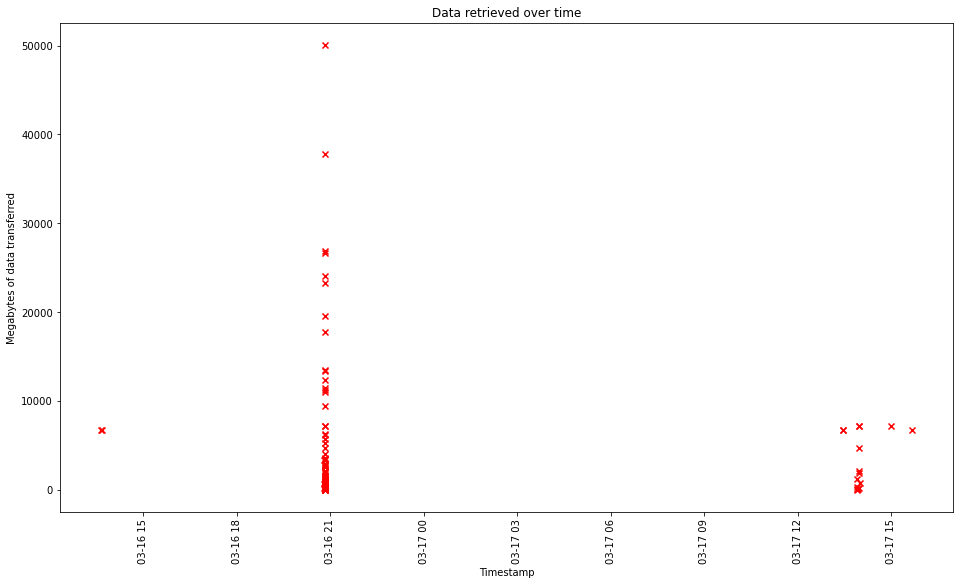

In [18]:
plt.figure(figsize=(16,9))
ftp_df_file2 = ftp_df_file[ftp_df_file["file_size"] < 2.585932e+06]
plt.scatter(ftp_df_file2["Timestamp"],ftp_df_file2["file_size"],marker ="x",c = "red")
plt.xlabel("Timestamp")
plt.ylabel("Megabytes of data transferred")
plt.title("Data retrieved over time")
plt.xticks(rotation=90)

We can see here that despite having 101 seperate transfers as we detailed earlier, they are not consistent transfers spanning the time frame. Most seem to be group around 3 major periods:
* The 16th March at around 13:30
* The 16th March at just before 21:00
* The 17th March approximately around 14:00, but a couple of transfers were seen later at about 15:00 and 16:00.

If we look at our previous plot, we can see that the large download of 2.5 MB was in the second period, just before 21:00.

([], <a list of 0 Text major ticklabel objects>)

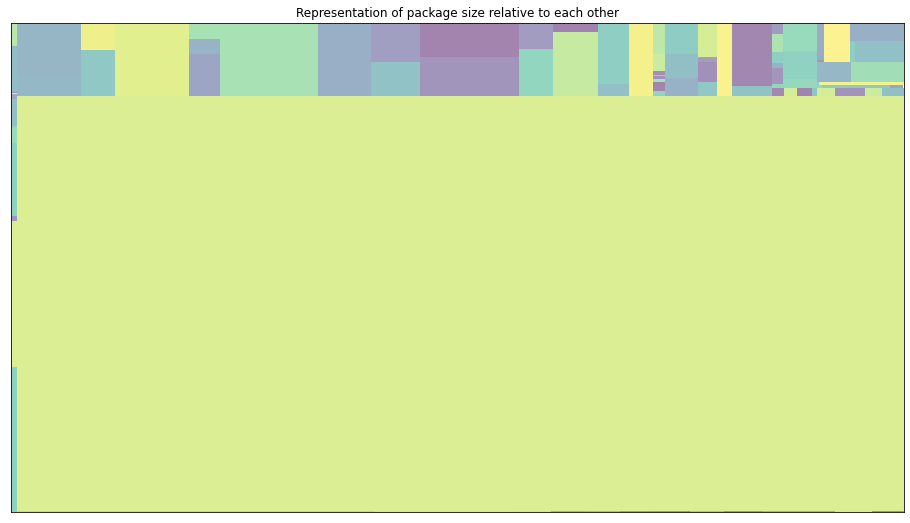

In [19]:
plt.figure(figsize=(16,9))
squarify.plot(sizes = ftp_df_file["file_size"], alpha=.5)
plt.title("Representation of package size relative to each other")
plt.xticks(ticks = [])
plt.yticks(ticks = [])

The above treeplot (using the 3rd party package squarify) shows the size of all 101 packets relative to each other. This is a pleasing visual representation, where the large area represents the 2.5 MB file, which we can see clearly dwarfs all others transferred in the time frame of the data set. 

In [20]:
#ftp_df_file3 = ftp_df_file
#ftp_df_file3["file_size"] = [int(i) for i in ftp_df_file3['file_size'].values]
#ftp_df_file3['file_size'] = ftp_df_file3['file_size'].apply(lambda x: [y if y >= 5000 else "" for y in x])
#ftp_df_file3
#ftp_df_file3["file_size"] = ftp_df_file["file_size"].apply(lambda x: [y if y <= 9 else 11 for y in x])
#ftp_df_file3.head()

### Specific analysis of the command protocols

I'm also interested in looking at the command column of the dataframe to see what are the most common called commands on the FTP protocol. We use the groupby function in order to count the number of each command, then convert this to a dataframe, and then we have to reset the index, else we have an extra row. On my first attempt I could not properly name the columns as the index was out and I recieved an error so I had to go back and fix this.

In [21]:
commands = ftp_df.groupby('command').size().sort_values(ascending=False)
commands = pd.DataFrame(commands)
commands.reset_index(level=0, inplace=True)
commands.columns = ['Command','Count']
commands

,Command,Count
0,PASV,2830
1,STOR,1353
2,DELE,1351
3,RETR,112
4,PORT,78
5,APPE,72


Text(0.5, 1.0, 'Number of times each command is used in the FTP Data')

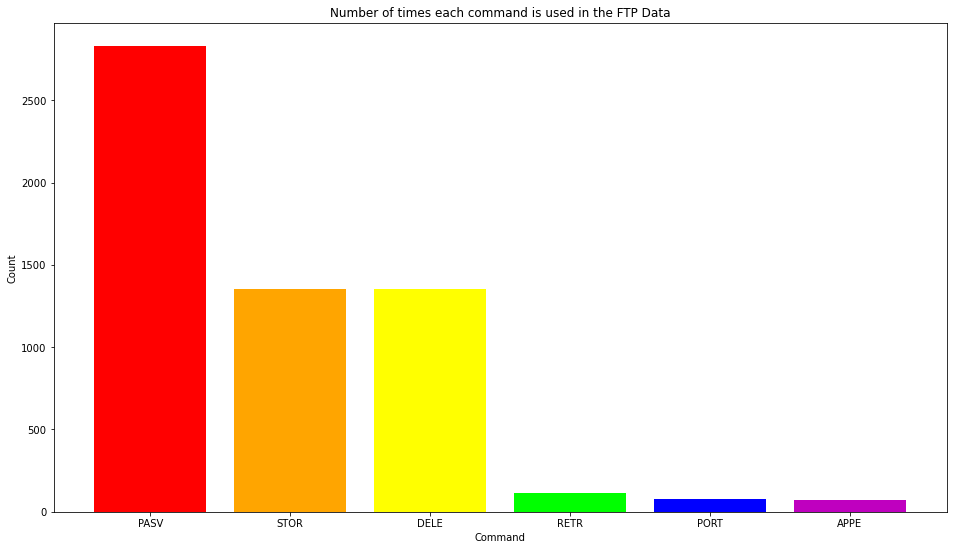

In [22]:
plt.figure(figsize=(16,9))
plt.bar(commands["Command"],commands["Count"],color = ("r","orange","yellow","lime","blue","m"))
plt.xlabel("Command")
plt.ylabel("Count")
plt.title("Number of times each command is used in the FTP Data")

We see that the command with by far the most usage in the data set is the PASV command. I conducted some research into FTP commands and found that PASV is a "port-defining" command. This means that it specifies which port is used to connect at the client side. PASV itself doesn't take any arguments as it allows the server that is being connected to, to choose a suitable port for itself. The less occurent in our dataset PORT command takes an argument that lets the client specify which port to use.

The other commands are all known as file transfer or management commands and are as follows.

* STOR - used by the client to store files on the server.
* DELE - used to delete a file from a directory.
* RETR - used by the client to retrieve files from the server.
* APPE - used by the client to append data to a file if it already exists or STOR it if not.

If we use the counting protocol above but this time on our sub dataset of values with file_size more than 0 we find:

In [23]:
commands_file = ftp_df_file.groupby('command').size().sort_values(ascending=False)
commands_file = pd.DataFrame(commands_file)
commands_file.reset_index(level=0, inplace=True)
commands_file.columns = ['Command','Count']
commands_file

,Command,Count
0,RETR,101


All of our entries where the file size is more than 0 use the RETR command. It would seem that the file size in this data set is only measured when the client is retrieving data from the server.

## Analysis of the UNSW-NB15 dataset

The UNSW-NB15 dataset was created by the University of New South Wales, featuring captured real network traffic data and created network attack data. I have decided to analyse the reduced "testing" dataset as even one of the 4 datasets that makes up the total 2.5 million records of the full dataset are extremely large to analyse.

In [26]:
url = "https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv"
df_unsw = pd.read_csv(url)
df_unsw1 = df_unsw

In [27]:
df_unsw.head(10)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.09020,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.00030,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.00510,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.66080,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.00250,...,1,3,0,0,0,2,3,0,Normal,0
5,6,0.000003,udp,-,INT,2,0,784,0,333333.32150,...,1,2,0,0,0,2,2,0,Normal,0
6,7,0.000006,udp,-,INT,2,0,1960,0,166666.66080,...,1,2,0,0,0,2,2,0,Normal,0
7,8,0.000028,udp,-,INT,2,0,1384,0,35714.28522,...,1,3,0,0,0,1,3,0,Normal,0
8,9,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0
9,10,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0


Even using the reduced testing set it's interesting to note that running the above code takes quite some time to run. As we can see in the describe function below this is is because even at a reduced sized, there are still 82332 entries in the dataset that have to be read into the dataframe.

In [28]:
df_unsw.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,...,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


We will create a brief data quality report of the UNSW data as we did with the FTP data.

In [29]:
#DataFrame with columns
columns = pd.DataFrame(list(df_unsw.columns.values[1:]))

#DataFrame with data types
data_types = pd.DataFrame(df_unsw.dtypes, columns=['Data Type'])

#DataFrame with Count
data_count = pd.DataFrame(df_unsw.count(), columns=['Count'])

#DataFrame with unique values
unique_value_counts = pd.DataFrame(columns=['Unique Values'])
for v in list(df_unsw.columns.values):
    unique_value_counts.loc[v] = [df_unsw[v].nunique()]

missing_data_counts = pd.DataFrame(df_unsw.isnull().sum(), columns=['Missing Values'])
data_quality_report = data_types.join(data_count).join(unique_value_counts).join(missing_data_counts)
print('Data Quality Report')
data_quality_report

Data Quality Report


,Data Type,Count,Unique Values,Missing Values
id,int64,82332,82332,0
dur,float64,82332,39888,0
proto,object,82332,131,0
service,object,82332,13,0
state,object,82332,7,0
spkts,int64,82332,420,0
dpkts,int64,82332,436,0
sbytes,int64,82332,4489,0
dbytes,int64,82332,4034,0
rate,float64,82332,40616,0


Looking back up at our head() call above we find some columns that do not seem to have interesting data in and the data actually seems to be compressed in the middle, resulting in some columns being filtered out we will use some code to filter down the dataframe.

In [30]:
df_unsw_red = df_unsw.drop(["id","service","ct_dst_sport_ltm","ct_dst_src_ltm","is_ftp_login","ct_ftp_cmd","ct_flw_http_mthd","ct_src_ltm","ct_srv_dst","is_sm_ips_ports","label","ackdat","smean","dmean","trans_depth","response_body_len","ct_srv_src","ct_state_ttl","ct_dst_ltm","ct_src_dport_ltm","dinpkt","sjit","djit","swin","stcpb","dtcpb","dwin","tcprtt","synack","sttl","dttl","sload","dload","sloss","dloss","sinpkt"],axis=1)
df_unsw_red.head()

,dur,proto,state,spkts,dpkts,sbytes,dbytes,rate,attack_cat
0,0.000011,udp,INT,2,0,496,0,90909.0902,Normal
1,0.000008,udp,INT,2,0,1762,0,125000.0003,Normal
2,0.000005,udp,INT,2,0,1068,0,200000.0051,Normal
3,0.000006,udp,INT,2,0,900,0,166666.6608,Normal
4,0.000010,udp,INT,2,0,2126,0,100000.0025,Normal


As is visible in the code above, I've had to remove a lot of additional columns that I am not interested in analysing, mostly because I do not understand what they are representing. This was very time consuming, and highlights issues with analysing large data sets.

My current interpretation of the reduced data set df_unsw_red is that dur represents the duration of connection and proto obviously represents the protocol (evidence by udp in the column). I also am interpreting that spkts/sbytes and dpkts/dbytes go hand in hand representing the number of of sent/downloaded packets of data and the total file size in bytes.

### Specific analysis of protocols

First of all I want to take a look at the different protocols taking place using the same method of groupby I used in earlier analysis.

In [31]:
protocol = df_unsw_red.groupby("proto").size().sort_values(ascending=False)
protocol = pd.DataFrame(protocol)
protocol.reset_index(level=0, inplace=True)
protocol.columns = ['Protocol','Count']
protocol

,Protocol,Count
0,tcp,43095
1,udp,29418
2,unas,3515
3,arp,987
4,ospf,676
...,...,...
126,pvp,32
127,qnx,32
128,3pc,32
129,ib,31


We see that we have rather a large number of protocols found in the data set so we are going to look at the top 15 most frequent for now.

In [32]:
proto15 = protocol.head(15)
proto15

,Protocol,Count
0,tcp,43095
1,udp,29418
2,unas,3515
3,arp,987
4,ospf,676
5,sctp,324
6,any,96
7,gre,88
8,rsvp,64
9,ipv6,61


It's worth noting from observation here that the bottom most count of hmp is 33 entries, comparing with our 126th original entry at 32. Let's analyse this a bit further with describe.

In [33]:
protocol.describe()

,Count
count,131.000000
mean,628.488550
std,4544.569172
min,30.000000
25%,32.000000
50%,32.000000
75%,33.000000
max,43095.000000


Surely enough we see that while the mean is around 628 due to the sheer size of the top values, the quartiles all fall around the 32/33 mark meaning that most of the protocols are used less than 34 times in 82332 length dataset.

We'll now go back to our reduced top 15 list and represent it with a treemap.

([], <a list of 0 Text major ticklabel objects>)

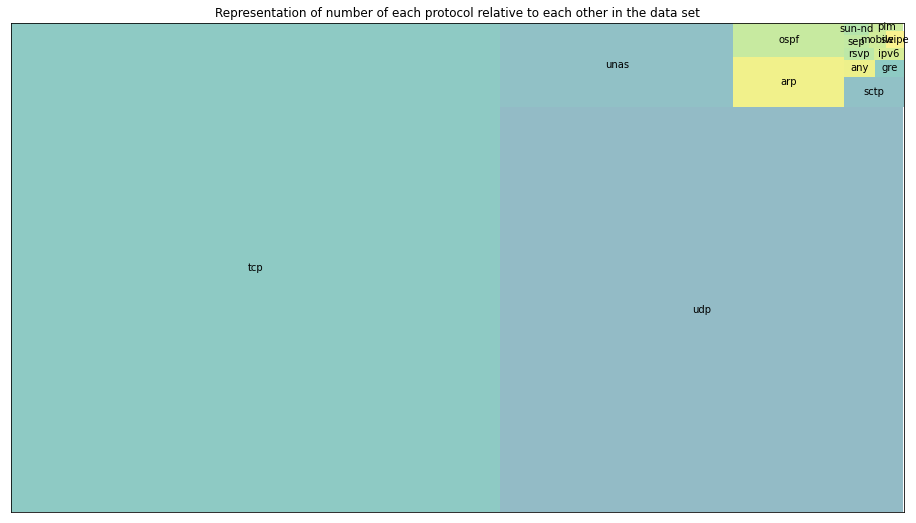

In [34]:
plt.figure(figsize=(16,9))
squarify.plot(sizes = proto15["Count"], label = proto15["Protocol"],alpha=.5)
plt.title("Representation of number of each protocol relative to each other in the data set")
plt.xticks(ticks = [])
plt.yticks(ticks = [])

As we can see TCP makes up more than half of the total protocols used in the dataset, and is followed very obviously by UDP, this makes sense as TCP and UDP two of the most commonly used internet protocols.

### Specific analysis of data packets

First of all here I am going to plot a scatter graph of the the amount of sent and recieved data from sbytes and dbytes, against the duration that the connection was open for and am hoping to see a positive correlation between the two, as a longer connection would allow for more data to be transferred and vice versa.

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text major ticklabel objects>)

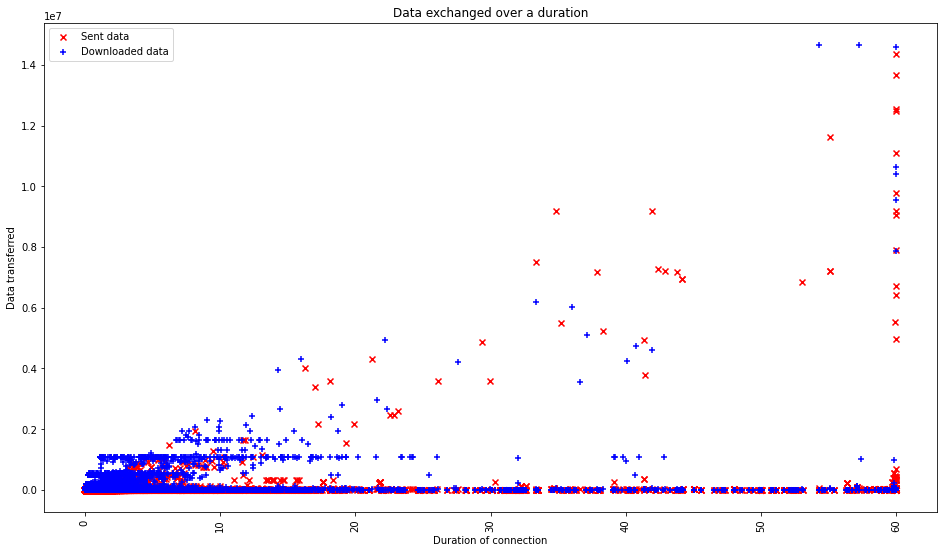

In [35]:
plt.figure(figsize=(16,9))
plt.scatter(df_unsw_red["dur"],df_unsw_red["sbytes"],marker ="x",c = "red")
plt.scatter(df_unsw_red["dur"],df_unsw_red["dbytes"],marker ="+",c = "blue")
plt.xlabel("Duration of connection")
plt.ylabel("Data transferred")
plt.title("Data exchanged over a duration")
plt.legend(['Sent data', 'Downloaded data'])
plt.xticks(rotation=90)

We see that there does seem to be somewhat of a positive correlation but also an awful lot of plots along the bottom of the graph. This could be because these are different connections with different protocols that aren't sending or recieving any specific data to or from the server so we will try plotting this again but first filterring out very small values.

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text major ticklabel objects>)

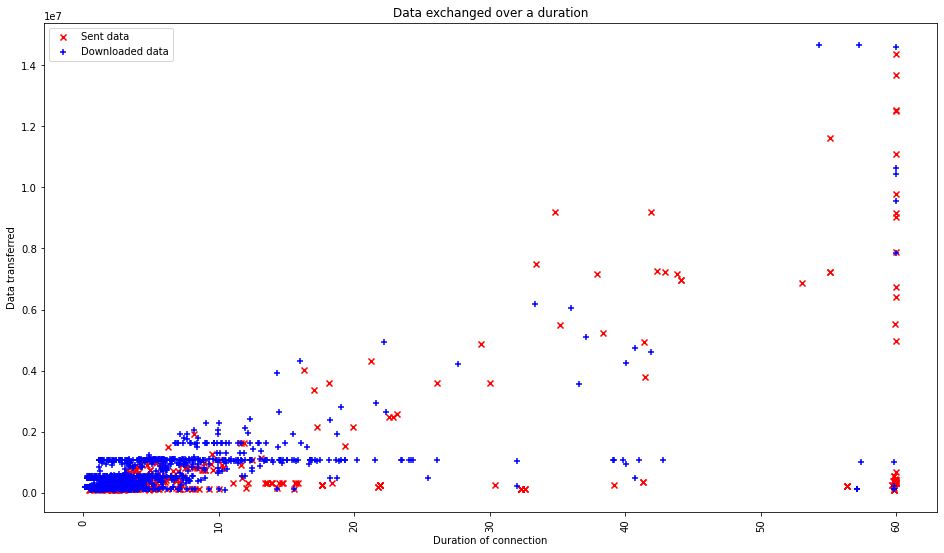

In [36]:
plt.figure(figsize=(16,9))
df_unsw_red2 = df_unsw_red[df_unsw_red["sbytes"] > 100000]
df_unsw_red3 = df_unsw_red[df_unsw_red["dbytes"] > 100000]
plt.scatter(df_unsw_red2["dur"],df_unsw_red2["sbytes"],marker ="x",c = "red")
plt.scatter(df_unsw_red3["dur"],df_unsw_red3["dbytes"],marker ="+",c = "blue")
plt.xlabel("Duration of connection")
plt.ylabel("Data transferred")
plt.title("Data exchanged over a duration")
plt.legend(['Sent data', 'Downloaded data'])
plt.xticks(rotation=90)

This is the state of our plot after removing all data packets that were smaller than 10kb from the plot. We still see there are quite a few outliers from the general trend. Also long connections with large amounts of data transferred are not common, most of the connections, while following a trend are found in the lower left portion of the graph.

Another theory I have is that the more data transferred, the greater number of packets would be used to transfer the data. We'll plot another scatter graph to test this hypothesis.

(array([-2000000.,        0.,  2000000.,  4000000.,  6000000.,  8000000.,
        10000000., 12000000., 14000000., 16000000.]),
 <a list of 10 Text major ticklabel objects>)

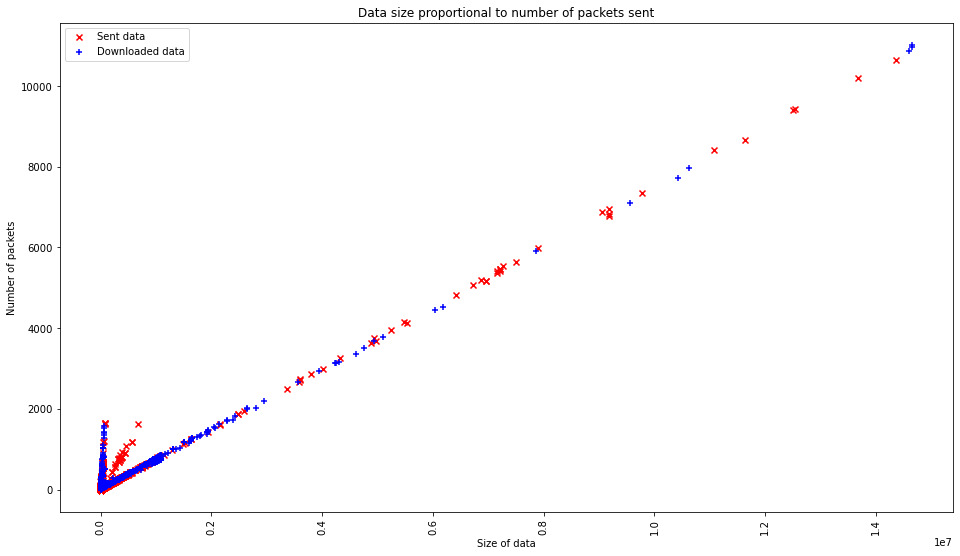

In [37]:
plt.figure(figsize=(16,9))
plt.scatter(df_unsw_red["sbytes"],df_unsw_red["spkts"],marker ="x",c = "red")
plt.scatter(df_unsw_red["dbytes"],df_unsw_red["dpkts"],marker ="+",c = "blue")
plt.xlabel("Size of data")
plt.ylabel("Number of packets")
plt.title("Data size proportional to number of packets sent")
plt.legend(['Sent data', 'Downloaded data'])
plt.xticks(rotation=90)

Success! We can see that the size of the total data sent clearly correlates to the number of packets required to send it.

### Analysis of cybersecurity attacks

We are going to look at the attack_cat column of our data, which details different categories of cyber attacks on the network.

In [38]:
cat = df_unsw_red.groupby("attack_cat").size().sort_values(ascending=False)
cat = pd.DataFrame(cat)
cat.reset_index(level=0, inplace=True)
cat.columns = ['attack_cat','Count']
cat

,attack_cat,Count
0,Normal,37000
1,Generic,18871
2,Exploits,11132
3,Fuzzers,6062
4,DoS,4089
5,Reconnaissance,3496
6,Analysis,677
7,Backdoor,583
8,Shellcode,378
9,Worms,44


We remove all normal traffic from our dataframe:

In [39]:
cat_attack = df_unsw_red[df_unsw_red.attack_cat != "Normal"]

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

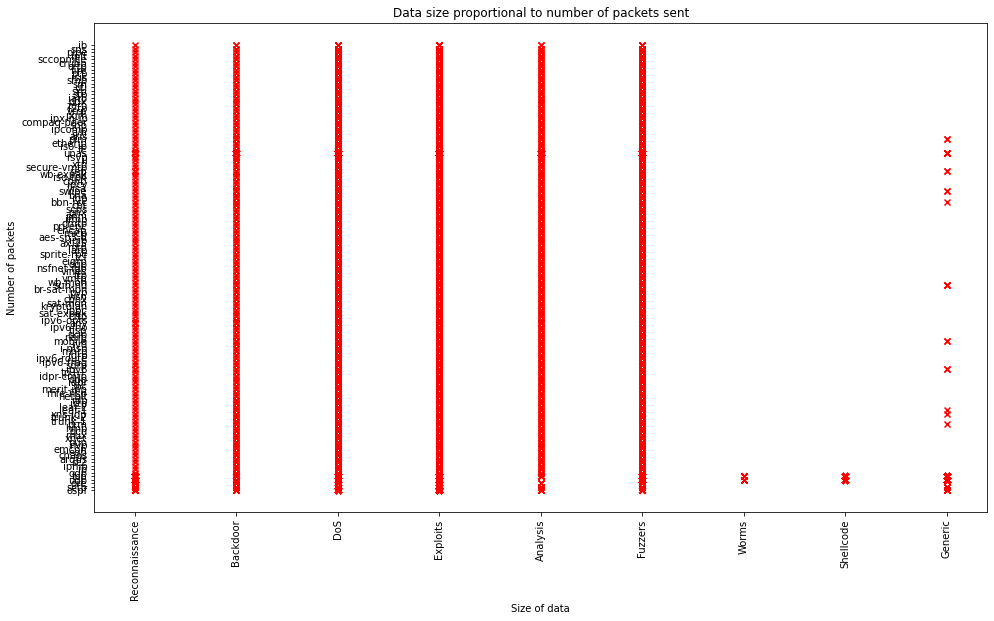

In [40]:
plt.figure(figsize=(16,9))
plt.scatter(cat_attack["attack_cat"],cat_attack["proto"],marker ="x",c = "red")
plt.xlabel("Attack type")
plt.ylabel("Protocol")
plt.title("Cyber attacks relating to protocol used")
plt.xticks(rotation=90)

While much of the data here is unreadable due to the shear number of protocols employed, we can see some interesting results. It seems that the first 6 types of attack target with a huge variety of protocols, while the protocols used by Worms, Shellcode, and Generic attacks has significantly less variety.

Due to the smaller frequency of Worm and Shellcode attacks acording to our groupby above, it makes sense that they would have fewer entries but, Generic attacks were the second most frequent after normal network activity so it's surprising to see attacks with fewer protocols from these.

We'll look at these a bit closer repeating stome steps we conducted above.

([0, 1, 2], <a list of 3 Text major ticklabel objects>)

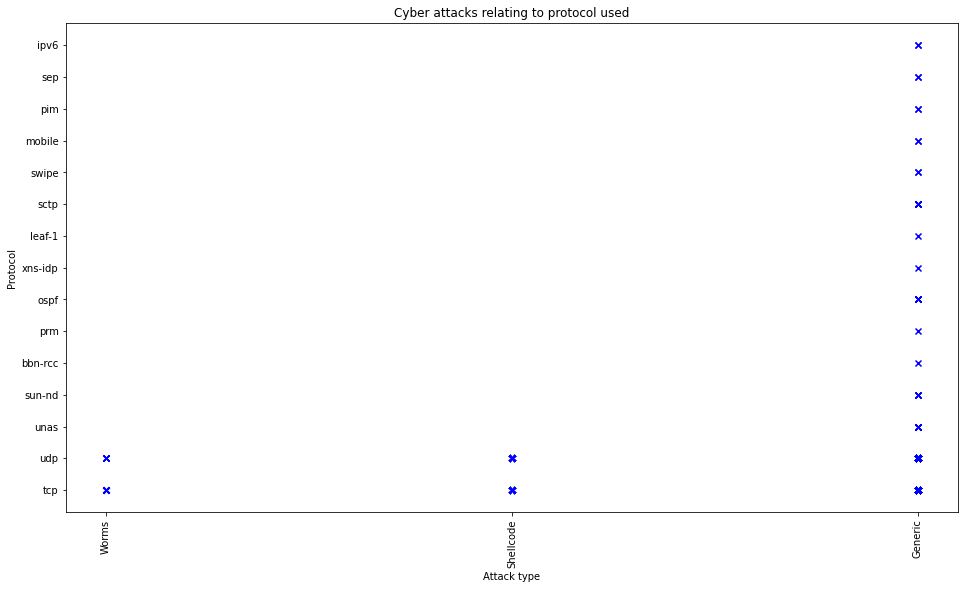

In [60]:
ca1 = cat_attack[cat_attack.attack_cat == "Worms"]
ca2 = cat_attack[cat_attack.attack_cat == "Shellcode"]
ca3 = cat_attack[cat_attack.attack_cat == "Generic"]
cat_attack_red = pd.concat([ca1, ca2, ca3], ignore_index=True)
plt.figure(figsize=(16,9))
plt.scatter(cat_attack_red["attack_cat"],cat_attack_red["proto"],marker ="x",c = "blue")
plt.xlabel("Attack type")
plt.ylabel("Protocol")
plt.title("Cyber attacks relating to protocol used")
plt.xticks(rotation=90)

As we can see above, reducing the data down to just those three attack types makes the scatter plot far more readable, and we see that Worms and Shellcode only seem to attack over the UDP and TCP protocol, and while Generic attacks do happen over others, the extra boldness of the plots on the UDP and TCP protocol suggest that it those attacks are also commonly done over those protocols as well.

## Resources

[Secrepo - source of security data](http://www.secrepo.com/)

[FTP Commands detailed](https://www.educba.com/ftp-commands/)

[ftp.csv dataset (Google Drive Link)](https://drive.google.com/file/d/1WemTdLui2MkjG_9ykm2_KPhL1FFfKmiL/view)

[UNSW-NB15 Dataset](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/)

[Stack Overflow resource that helped with downloading files from Google Drive](https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public)